# System Demo

## Imports

In [1]:
import torch
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, get_transform
from project.utils import collatev2
from project.utils import compute_statistics
from project.model import RPN, ISAVIT, Feeder
import random
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

## Config Initialization

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### ISA-RPN configs

In [3]:
image_size = 300
patch_size = 32

In [4]:
rpn = RPN(
        input_dim=512,
        output_dim=4,
        image_size=image_size,
        global_context=True,
        nh=4,
        pretrained=False
    ).to(device)

324


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Feeder

In [5]:
resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)

### ISA-ViT configs

In [6]:
vit = ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600,
        global_context=True,
    ).to(device)

### Load Weights

In [7]:
rpn.load_state_dict(torch.load('best_fold_weights/isa-rpn/LATEST_rpn_fold2.pt'))

<All keys matched successfully>

In [8]:
vit.load_state_dict(torch.load('best_fold_weights/perfect-bbox_isa-vit/vit_fold1.pt'))

<All keys matched successfully>

## Dataset Loading

In [9]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

### Target slices that have cmbs

In [10]:
positive_data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
positive_data.shape

(364, 9)

In [11]:
test_size=0.2
random_state=12

In [12]:
_, test_case = train_test_split(
    positive_data,
    test_size=test_size,
    random_state=random_state
)

## Test Cases Combined

### DataFrame of Test Cases

In [13]:
test_cases = pd.DataFrame(test_case)
test_cases = test_cases.reset_index(drop=True)
test_cases

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,123,1,1,2,67080.070312,192
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,138,1,1,2,72055.335938,192
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,93,1,1,2,65800.148438,192
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,119,1,1,2,72814.117188,192
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,52,1,1,2,79978.382812,192
...,...,...,...,...,...,...,...,...,...
68,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,13,1,1,3,429.000000,39
69,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,62,1,1,2,70285.921875,192
70,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,90,1,1,2,70285.921875,192
71,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,13,1,1,3,234.000000,39


In [14]:
from sklearn.model_selection import train_test_split

def make_dataset(data,
                 cohort,
                 skull_stripped,
                 target_shape=(300, 300),
                ):
    data = data[data.cohort == cohort]
    
    s = f'Creating dataset for Cohort {cohort}\n'

    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=False,
        normalization=(global_min, global_max)
    )

    if skull_stripped == True:
        dataset = VALDODataset(
            cases=data.stripped.tolist(),
            masks=data.masks.tolist(),
            target=data.target.tolist(),
            transform=transform
        )
    else:
        dataset = VALDODataset(
            cases=data.mri.tolist(),
            masks=data.masks.tolist(),
            target=data.target.tolist(),
            transform=transform
        )
    return dataset

### Dataset made of Raw MRI

In [15]:
raw_dataset_cohort1 = make_dataset(data=test_cases, cohort=1, skull_stripped=False)
raw_dataset_cohort3 = make_dataset(data=test_cases, cohort=3, skull_stripped=False)

test_cases_dataset_raw = ConcatDataset([raw_dataset_cohort1, raw_dataset_cohort3])
test_cases_dataset_raw_dl = DataLoader(
    test_cases_dataset_raw,
    shuffle=False,
    batch_size=test_cases_dataset_raw.__len__(),
    collate_fn=collatev2
)

### Dataset made of Skull-stripped MRI

In [16]:
stripped_dataset_cohort1 = make_dataset(data=test_cases, cohort=1, skull_stripped=True)
stripped_dataset_cohort3 = make_dataset(data=test_cases, cohort=3, skull_stripped=True)

test_cases_dataset_stripped = ConcatDataset([stripped_dataset_cohort1, stripped_dataset_cohort3])
test_cases_dataset_stripped_dl = DataLoader(
    test_cases_dataset_stripped,
    shuffle=False,
    batch_size=test_cases_dataset_stripped.__len__(),
    collate_fn=collatev2
)

In [17]:
def make_feedset(
        data,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )
    feedset = VALDODataset(
    cases=data.stripped,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [18]:
feedset = make_feedset(
    data=data,
    rpn_mode=True,
    target_shape=(300, 300)
)

Creating feedset
Total Unique MRI Samples in data_train: 72
GLOBAL MIN & MAX (0.0, 87519.8515625)



## Prediction using the model

In [19]:
def predict(loader, stage1, stage2, feeder):
    Y = []
    T = []
    cases = []
    targets = []
    bbox_predictions = []
    with torch.inference_mode():
        for batch in loader:
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(device)
                masks = masks.float().to(device)

                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                bbox = bboxes[target].int().tolist()

                x = feeder(slices, bbox, 32)
                t = feeder(masks, bbox, 32)

                x = x.flatten(2).float().to(device)
                t = t.flatten(2).float().to(device)
                segmented_mask = stage2(x, target)

                Y.append(segmented_mask)
                T.append(t[target])
                cases.append(case)
                targets.append(target)
                bbox_predictions.append(bbox)

    return Y, T, cases, targets, bbox_predictions

In [20]:
predictions, ground_truths, cases, targets, bbox_predictions = predict(
    loader=test_cases_dataset_stripped_dl,
    stage1=rpn,
    stage2=vit,
    feeder=feeder
)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


## New Metrics test

In [21]:
from scipy.ndimage import label
import numpy as np
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import euclidean

def compute_centroid_distance(pred, anno):
    pred_centroid = center_of_mass(pred)
    anno_centroid = center_of_mass(anno)
    return euclidean(pred_centroid, anno_centroid)

In [22]:
for i in range(predictions.__len__()):
    predictions[i] = predictions[i].view(patch_size, patch_size).sigmoid().detach().cpu()
    ground_truths[i] = ground_truths[i].view(patch_size, patch_size).sigmoid().detach().cpu()

In [23]:
binary_annotation = (ground_truths[0] > 0.5).int().detach().cpu().numpy()
binary_prediction = (predictions[0] > 0.5).int().detach().cpu().numpy()

In [24]:
prediction_labeled, num_pred = label(binary_prediction, structure=np.ones((3,3)))
annotation_labeled, num_anno = label(binary_annotation, structure=np.ones((3,3)))

<Axes: >

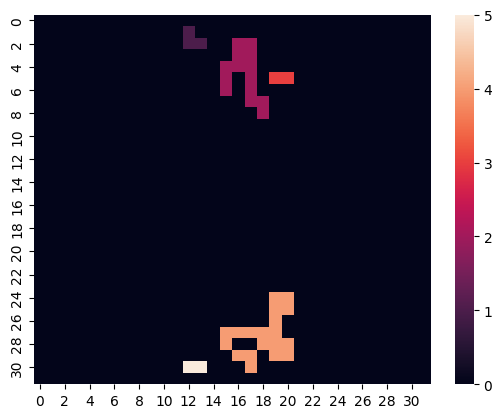

In [25]:
sns.heatmap(annotation_labeled)

In [26]:
# def count_fptpfn(pred_mask, anno_mask):
#     TP = 0
#     FP = 0
#     FN = 0
#     threshold = 0.5
#     pred_mask = (pred_mask > threshold).int().numpy()
#     if all(np.equal(np.array([0, 1]), anno_mask.int().unique().numpy())) != True:
#         anno_mask = (anno_mask > min(anno_mask[0].unique()))
    
#     labeled_pred, num_pred = label(pred_mask, structure=np.ones((3,3)))
#     labeled_anno, num_anno = label(anno_mask, structure=np.ones((3,3)))

#     used_predictions = []

#     for anno_index in range(1, num_anno + 1):
#         cur_anno_mask = (labeled_anno == anno_index)
#         best_match = None
#         best_value = None

#         for pred_index in range(1, num_pred + 1):
#             if pred_index in used_predictions:
#                 continue
                
#             cur_pred_mask = (labeled_pred == pred_index)
#             value = compute_centroid_distance(cur_pred_mask, cur_anno_mask)
#             if value < 5.0:
#                 if best_value is None or value < best_value:
#                     best_match = pred_index
#                     best_value = value

#         if best_match is not None:
#             TP += 1
#             used_predictions.append(best_match)
#         else:
#             FN += 1
    
#     FP = num_pred - len(used_predictions)

#     return TP, FP, FN

In [27]:
from project.evaluation import isa_vit_metric, count_fptpfn

In [28]:
TP = 0
FP = 0
FN = 0
for i in range(predictions.__len__()):
    tp, fp, fn = count_fptpfn(predictions[i], ground_truths[i])

    TP += tp
    FP += fp
    FN += fn

print(TP, FP, FN)

14 2 9


In [29]:
dice_score, precision_score, recall_score, f1_score, fp_avg = isa_vit_metric(TP, FP, FN, len(predictions))

In [30]:
print('Precision:', precision_score)
print('Recall:', recall_score)
print('F1:', f1_score)
print('FPavg:', fp_avg)
print('Dice:', dice_score)

Precision: 0.875
Recall: 0.6086956521739131
F1: 0.717948717948718
FPavg: 0.7777777777777778
Dice: 0.717948717948718


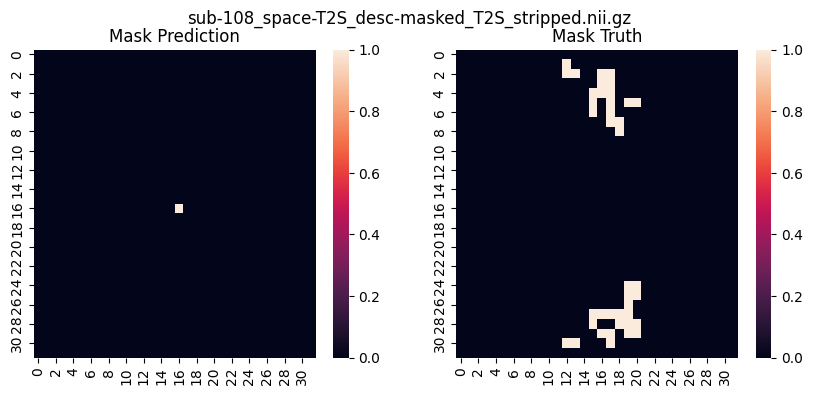

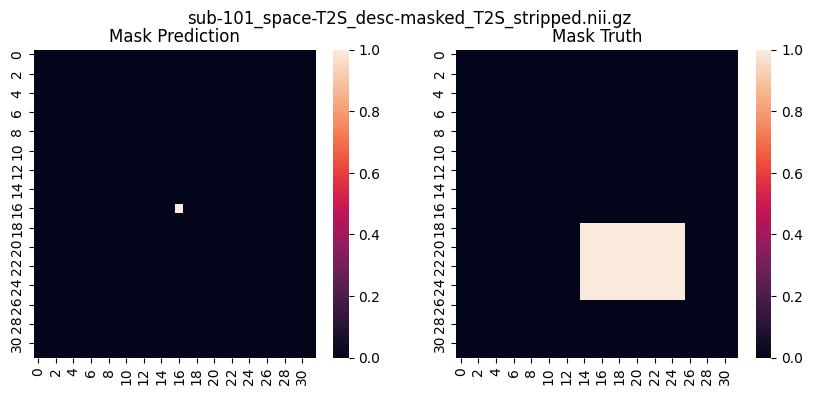

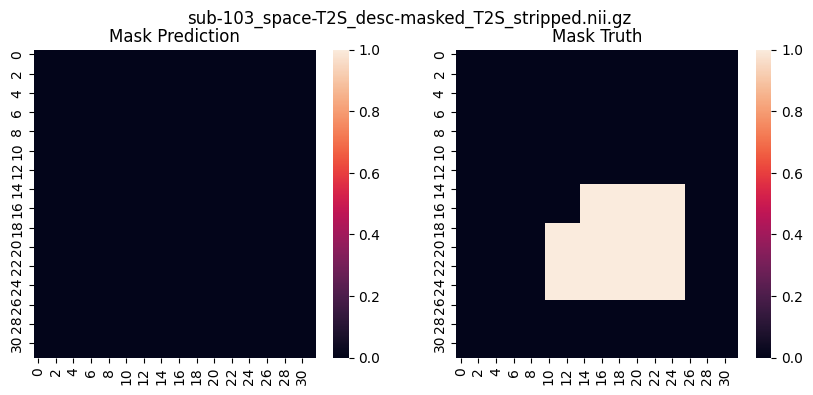

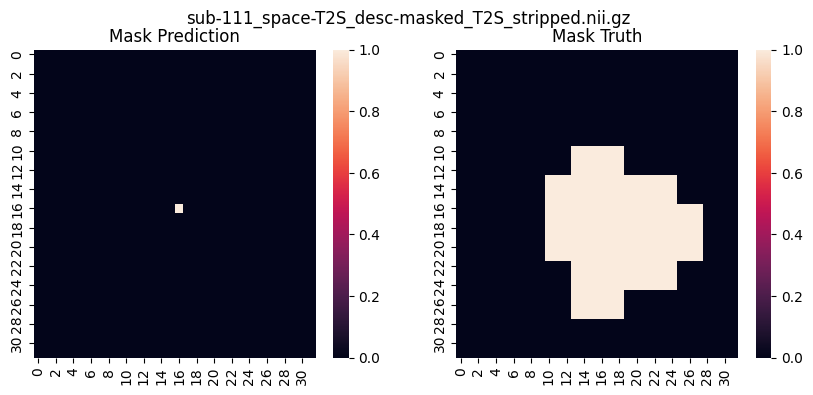

In [90]:
for i in range(4):
    # Prediction and ground truth plotting
    prediction = predictions[i]
    ground_truth = ground_truths[i]
    f, a = plt.subplots(1, 2, figsize=(10, 4))
    f.suptitle(cases[i].split('\\')[-1])
    ax1 = a.flat[0]
    ax2 = a.flat[1]
    ax1.set_title('Mask Prediction')
    ax2.set_title('Mask Truth')
    sns.heatmap((prediction > 0.5), ax=ax1, vmax=1)
    sns.heatmap((ground_truth > 0.5), ax=ax2, vmax=1)